In [292]:
import numpy as np
import random as rd
from keras.datasets import mnist



In [293]:
class Network:
    """
    The main object we're going to use accross this notebook
    It's a neural network that takes as input a list of 
    layers nodes
    
    Ex: [2, 3, 1] is a 3 layer network, with 2 neurons of input, 3 neurons 
    in the hidden layer and 1 for the output layer
    
    Supposedly it can take more than just 3 layers but I didnt test it
    
    It initializes an object with the proper weights, biases, activations and z
    based on the layers list. It also has the layers list and the number of layers
    
    The weights and biases initialized following a Gaussian of mean 1
    """
    def __init__(self, layers: list):        
        np.random.seed(42)        
        b = []
        w = []
        a = []
        z = []
        for l in range(0, len(layers)):
            # skipping one layer for the weights and biases
            if (l+1) < len(layers):
                b.append(np.random.normal(loc=0, scale=1,size=layers[l+1]))
                w.append(np.random.normal(loc=0,scale=1,size=[layers[l],layers[l+1]]))
            a.append(np.zeros(layers[l]))
            z.append(np.zeros(layers[l]))
    
        # b[i][j] -> "i" is which layer, "j" which neuron
        # w[i][j][k] -> "i" is which layer, "j" which neuron of the first layer, "k" which neuron of the second layer
        self.b = b
        self.w = w
        self.a = a
        self.z = z
        self.nLayers = len(layers)
        self.layers = layers

In [294]:
def ReLU(n: float):
    return max(0, n)


def ReLU_derivative(n: float):
    """Derivative of the ReLU function."""
    n = np.where(n > 0, 1, 0)
    return n

In [295]:
def sigmoid(n: float):
    return 1.0/(1.0+np.exp(-n))

def sigmoid_derivative(n: float):
    """Derivative of the sigmoid function."""
    return sigmoid(n)*(1-sigmoid(n))


In [297]:
def feedForward(net: Network) -> Network:
    """
    Feedforwading the activations to the next layer
    
    It will take as input the network already with the input image as the activation 
    on the first layer and then feedforward to the next layrse
    
    It returns the network with all the activations set
    """
    
    # resetting the activations as to not take any info from the activation of
    # the previous number while maintanin the first activation
    for i in range(1, net.nLayers):
        net.z[i] = np.zeros(net.layers[i])
        net.a[i] = np.zeros(net.layers[i])
    for l in range(0, net.nLayers-1):
        for receivingNeuron in range(net.layers[l+1]):
            for givingNeuron in range(net.layers[l]):
                net.z[l+1][receivingNeuron] += net.a[l][givingNeuron] * net.w[l][givingNeuron][receivingNeuron]
            net.z[l+1][receivingNeuron] += net.b[l][receivingNeuron]
            net.a[l+1][receivingNeuron] = sigmoid(net.z[l+1][receivingNeuron])

            
    return net
    
    

In [298]:
def setInput(net: Network, MNISTnumber):
    """
    Inputs the MNIST number into the network, since the number is a 28x28 matrix, 
    we transform it into a 784 array
    
    We also scale the pixels as to be between 0 and 1 for the sigmoid function 
    instead of 0 and 255
    
    Returns the network with the proper activations on all layers since it pass 
    through the feedforward step
    """
    numberArr = np.asarray(MNISTnumber).flatten()
    # scaling the array so that the range is between 0 and 1
    numberArr = np.interp(numberArr, (numberArr.min(), numberArr.max()), (0, 1))
    for i in range(net.layers[0]):
        net.z[0][i] = numberArr[i]
        net.a[0][i] = numberArr[i]
    net = feedForward(net)
    
    return net

The list below is all equations that were used to compute the erros and then propagate through the network:

To calculate the error on the last layer: 
$$\delta^L = (a^L - y)\odot \sigma'(z^L)$$

To calculate the error on the other layers:
$$\delta^l = ((w^{l+1})^T\delta^{l+1})\odot \sigma'(z^l)$$

To repass the error to the bias: 
$$\frac{\partial C}{\partial b^l_j} = \delta^l_j$$

To repass the error to the weights:
$$\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k\delta^l_j$$

In [299]:
def backProp(net: Network, y) -> Network:
    """
    The backpropagation step: first we calculate the error on the last layer, 
    then we pass to the previous layers all the while applying the error 
    to the weights and biases
    
    Example on a 3 layer network: We calculate the error on the last layer, 
    apply it to the last layer's weights and biases, and then calculate the 
    error on the next layer, propagate to the weights and biases and it's done
    
    It takes as input the network and the label of the number the network was activated on
    
    It returns the modifications to the weights and biases (nablaW and nablaB) 
    the network should have
    """
    layers = net.layers
    nablaB = [np.zeros(i.shape) for i in net.b]
    nablaW = [np.zeros(i.shape) for i in net.w]
    delta = np.zeros(10) # 10 because its the possible number of outputs
    for j in range(net.layers[-1]):
        if y == j:
            delta[j] += (net.a[-1][j] - 1)*sigmoid_derivative(net.z[-1][j])
        else:
            delta[j] += (net.a[-1][j] - 0)*sigmoid_derivative(net.z[-1][j])
    for l in range(net.nLayers-1, 0, -1):
        #nablaB and nablaW have -1 because they only have 2 layers instead of 3
        nablaB[l-1] = delta
                
        for j in range(layers[l]):
            for k in range(layers[l-1]):
                nablaW[l-1][k][j] += net.a[l-1][k]*delta[j]
        
        # finding the error one layer behind
        # in the book it needs a transpose because its weight[layer][receivingNeuron][givingNeuron]
        # but my implementation uses weight[layer][givingNeuron][receivingNeuron] so it's not necessary
        delta = (np.dot(net.w[l-1], delta))*sigmoid_derivative(net.z[l-1])
        
    return nablaB, nablaW


In [300]:
def SGD(net: Network, X: list, y: list, batchSize: int, nEpochs: int, learningRate) -> Network:
    """
    Implementation of Stochastic Gradient Descent
    
    It takes as input the network, the MNIST dataset, the MNIST labels of the dataset, 
    the size of the batch to do gradient descent, the number of epochs it should run,
    and the learning rate eta (I found the best eta to be in the order of 10s)
    
    It returns the best trained network in all epochs
    """
    bestAcc = 0
    bestEpoch = 0
    bestNet = net
    for epoch in range(nEpochs):
        batch = rd.sample(range(len(X)), batchSize)
        nablaB = [np.zeros(i.shape) for i in net.b]
        nablaW = [np.zeros(i.shape) for i in net.w]
        for i in batch:
            net = setInput(net, X[i])
            # finding what should be modified based on this particular example
            deltaNablaB, deltaNablaW = backProp(net, y[i])
            # passing this modifications to our overall modifications matrices
            for l in range(net.nLayers-1):
                nablaB[l] += deltaNablaB[l]
                nablaW[l] += deltaNablaW[l]
        
        # applying the changes to our network
        for l in range(net.nLayers-1):
            net.b[l] = net.b[l] - learningRate * (nablaB[l]/batchSize)
            net.w[l] = net.w[l] - learningRate * (nablaW[l]/batchSize)
        acc, outputs = testNetwork(net, X, y, batchSize=batchSize)
        if acc > bestAcc:
            bestAcc = acc
            bestEpoch = epoch
            bestNet = net
        print(f'learningRate: {learningRate} epochs: {epoch} acc: {acc}, outputs: {outputs}')
    print(f'best acc: {bestAcc} on epoch: {bestEpoch}')
    return bestNet
        

In [301]:
# initializing the network and the dataset

net = Network([784,30,10])
(train_X, train_y), (test_X, test_y) = mnist.load_data()



In [302]:
def testNetwork(net: Network, test_X, test_y, nTests: int):
    """
    A function to test our network
    
    It returns the overall accuracy and the numbers our network guessed
    """
    
    correctOutput = 0
    X = test_X[:batchSize]
    y = test_y[:batchSize]
    outputs = np.zeros(10)
    for i in range(nTests):
        net = setInput(net, X[i])
        networkOutput = np.argmax(net.a[-1])
        outputs[networkOutput] += 1
        #print(f"number: {y[i]}, networkOutput: {networkOutput}, activations: {net.a[-1]}")
        if y[i] == networkOutput:
            correctOutput += 1
    acc = correctOutput/batchSize
    return acc, outputs


In [303]:
def gridSearch(net: Network, train_X, train_y, test_X, test_y, batchSize: int, learningRates: list, epochs: int):
    """
    A function to perform a gridSearch in order to find the best learningRates

    It takes as input the network, the training images of MNIST, the training labels,
    the test images, the test labels, the batchSize for SGD,
    a list of learningRates as to find the best inside the list
    the number of epochs to perform SGD
    
    
    It returns the best network accross all learning rates list
    """
    bestNet = net
    bestAcc = 0
    for eta in learningRates:
        # resetting the network
        net = Network([784,30,10])
        net = SGD(net, train_X, train_y, batchSize=batchSize, nEpochs=epochs, learningRate=eta)
        acc, outputs = testNetwork(net, test_X, test_y, batchSize) 
        if acc > bestAcc:
            bestNet = net
            bestAcc = acc
    return bestNet


In [304]:
net = gridSearch(net, train_X, train_y, test_X, test_y, batchSize=100, learningRates=[10], epochs=500)

learningRate: 10 epochs: 0 acc: 0.18, outputs: [28.  0.  7.  3.  2.  3. 20. 33.  4.  0.]
learningRate: 10 epochs: 1 acc: 0.16, outputs: [36.  0.  7.  5.  3.  7.  8. 27.  5.  2.]
learningRate: 10 epochs: 2 acc: 0.16, outputs: [35.  0.  9.  5.  2.  8.  8. 22.  9.  2.]
learningRate: 10 epochs: 3 acc: 0.15, outputs: [28.  1.  8.  9.  3.  7.  6. 28.  7.  3.]
learningRate: 10 epochs: 4 acc: 0.15, outputs: [28.  1.  9. 11.  1. 10.  8. 21.  8.  3.]
learningRate: 10 epochs: 5 acc: 0.13, outputs: [35.  0. 11.  9.  1.  8.  6. 18.  9.  3.]
learningRate: 10 epochs: 6 acc: 0.17, outputs: [38.  0.  9.  5.  1.  7.  5. 26.  6.  3.]
learningRate: 10 epochs: 7 acc: 0.2, outputs: [50.  0.  9.  4.  1.  5.  1. 24.  3.  3.]
learningRate: 10 epochs: 8 acc: 0.17, outputs: [40.  0.  9.  5.  1.  6.  3. 25.  8.  3.]
learningRate: 10 epochs: 9 acc: 0.21, outputs: [54.  0.  9.  3.  1.  5.  0. 23.  3.  2.]
learningRate: 10 epochs: 10 acc: 0.19, outputs: [43.  0. 10.  4.  1.  6.  2. 25.  6.  3.]
learningRate: 10 epoc

learningRate: 10 epochs: 92 acc: 0.37, outputs: [15.  1.  1. 18.  0. 11.  1. 35. 18.  0.]
learningRate: 10 epochs: 93 acc: 0.39, outputs: [16.  1.  2. 18.  0. 14.  1. 29. 19.  0.]
learningRate: 10 epochs: 94 acc: 0.36, outputs: [13.  2.  2.  8.  0. 15.  0. 29. 30.  1.]
learningRate: 10 epochs: 95 acc: 0.34, outputs: [13.  3.  2. 11.  0. 10.  0. 29. 32.  0.]
learningRate: 10 epochs: 96 acc: 0.36, outputs: [17.  2.  2. 11.  0. 13.  0. 23. 32.  0.]
learningRate: 10 epochs: 97 acc: 0.4, outputs: [20.  3.  1. 21.  0.  9.  1. 31. 14.  0.]
learningRate: 10 epochs: 98 acc: 0.4, outputs: [26.  2.  3. 11.  0. 10.  1. 21. 26.  0.]
learningRate: 10 epochs: 99 acc: 0.42, outputs: [13. 16.  2.  9.  0. 12.  1. 29. 18.  0.]
learningRate: 10 epochs: 100 acc: 0.44, outputs: [21. 10.  4. 15.  1. 15.  1. 19. 14.  0.]
learningRate: 10 epochs: 101 acc: 0.44, outputs: [17.  9.  3. 11.  1. 19.  1. 21. 18.  0.]
learningRate: 10 epochs: 102 acc: 0.46, outputs: [15. 14.  3. 21.  0.  7.  1. 23. 16.  0.]
learningR

learningRate: 10 epochs: 183 acc: 0.75, outputs: [13. 11.  8. 14. 15.  5. 10. 13. 11.  0.]
learningRate: 10 epochs: 184 acc: 0.74, outputs: [13. 14.  6. 13. 13.  7. 10. 13. 11.  0.]
learningRate: 10 epochs: 185 acc: 0.76, outputs: [13. 12.  6. 10. 16.  6. 11. 12. 14.  0.]
learningRate: 10 epochs: 186 acc: 0.75, outputs: [14. 14.  4. 14. 13.  6. 11. 13. 11.  0.]
learningRate: 10 epochs: 187 acc: 0.74, outputs: [13. 13.  6. 16. 13.  5. 10. 13. 11.  0.]
learningRate: 10 epochs: 188 acc: 0.74, outputs: [13. 12.  6. 16. 14.  4. 11. 14. 10.  0.]
learningRate: 10 epochs: 189 acc: 0.74, outputs: [13. 12.  8. 13. 13.  5. 10. 15. 11.  0.]
learningRate: 10 epochs: 190 acc: 0.74, outputs: [13. 12.  8. 13. 11.  7. 12. 14. 10.  0.]
learningRate: 10 epochs: 191 acc: 0.77, outputs: [14. 11.  4. 16. 15.  4. 13. 13. 10.  0.]
learningRate: 10 epochs: 192 acc: 0.73, outputs: [14. 11.  4. 14. 14.  7. 11. 13. 12.  0.]
learningRate: 10 epochs: 193 acc: 0.73, outputs: [13. 11.  7. 13. 12.  7. 11. 16. 10.  0.]

learningRate: 10 epochs: 274 acc: 0.84, outputs: [14. 13.  5. 14. 12.  5. 11. 17.  9.  0.]
learningRate: 10 epochs: 275 acc: 0.84, outputs: [14. 13.  5. 14. 14.  5. 12. 14.  9.  0.]
learningRate: 10 epochs: 276 acc: 0.83, outputs: [14. 12.  5. 14. 15.  5. 12. 15.  8.  0.]
learningRate: 10 epochs: 277 acc: 0.83, outputs: [14. 14.  5. 14. 14.  5. 12. 14.  8.  0.]
learningRate: 10 epochs: 278 acc: 0.82, outputs: [14. 15.  5. 14. 15.  5. 12. 13.  7.  0.]
learningRate: 10 epochs: 279 acc: 0.82, outputs: [14. 14.  5. 13. 15.  7. 12. 12.  8.  0.]
learningRate: 10 epochs: 280 acc: 0.83, outputs: [14. 14.  5. 14. 15.  5. 12. 13.  8.  0.]
learningRate: 10 epochs: 281 acc: 0.83, outputs: [14. 14.  5. 14. 15.  5. 12. 13.  8.  0.]
learningRate: 10 epochs: 282 acc: 0.82, outputs: [14. 15.  5. 14. 15.  3. 12. 13.  9.  0.]
learningRate: 10 epochs: 283 acc: 0.82, outputs: [14. 15.  5. 14. 15.  4. 12. 12.  9.  0.]
learningRate: 10 epochs: 284 acc: 0.81, outputs: [14. 14.  5. 14. 12.  4. 12. 17.  8.  0.]

learningRate: 10 epochs: 365 acc: 0.85, outputs: [14. 12.  6. 12. 12.  5. 12. 12. 10.  5.]
learningRate: 10 epochs: 366 acc: 0.86, outputs: [14. 13.  6. 13. 12.  4. 12. 12. 10.  4.]
learningRate: 10 epochs: 367 acc: 0.88, outputs: [14. 12.  6. 13.  9.  4. 12. 12.  9.  9.]
learningRate: 10 epochs: 368 acc: 0.86, outputs: [14. 12.  5. 13. 10.  6. 12. 14. 11.  3.]
learningRate: 10 epochs: 369 acc: 0.87, outputs: [14. 12.  3. 13. 11.  5. 13. 13. 12.  4.]
learningRate: 10 epochs: 370 acc: 0.87, outputs: [14. 12.  5. 13. 10.  5. 12. 12. 10.  7.]
learningRate: 10 epochs: 371 acc: 0.87, outputs: [15. 12.  4. 14. 10.  6. 12. 13.  8.  6.]
learningRate: 10 epochs: 372 acc: 0.88, outputs: [14. 12.  5. 14.  9.  5. 12. 12.  9.  8.]
learningRate: 10 epochs: 373 acc: 0.86, outputs: [15. 12.  4. 13.  6.  5. 12. 11.  9. 13.]
learningRate: 10 epochs: 374 acc: 0.85, outputs: [15. 12.  4. 14. 13.  5. 12. 14.  9.  2.]
learningRate: 10 epochs: 375 acc: 0.88, outputs: [14. 12.  7. 10. 13.  6. 12. 13.  9.  4.]

learningRate: 10 epochs: 456 acc: 0.87, outputs: [14. 13.  5. 12. 12.  7. 12. 12.  8.  5.]
learningRate: 10 epochs: 457 acc: 0.87, outputs: [14. 13.  5. 12. 12.  7. 12. 12.  8.  5.]
learningRate: 10 epochs: 458 acc: 0.9, outputs: [14. 13.  5. 11. 12.  6. 12. 11.  9.  7.]
learningRate: 10 epochs: 459 acc: 0.91, outputs: [14. 13.  6. 12. 10.  7. 12. 10.  8.  8.]
learningRate: 10 epochs: 460 acc: 0.9, outputs: [14. 13.  6. 12. 10.  7. 12.  9.  8.  9.]
learningRate: 10 epochs: 461 acc: 0.89, outputs: [14. 13.  5. 12. 11.  7. 12. 11.  8.  7.]
learningRate: 10 epochs: 462 acc: 0.89, outputs: [14. 13.  5. 14. 11.  6. 11. 12.  8.  6.]
learningRate: 10 epochs: 463 acc: 0.91, outputs: [14. 13.  6. 12. 10.  7. 12. 10.  8.  8.]
learningRate: 10 epochs: 464 acc: 0.87, outputs: [14. 13.  5. 12. 12.  7. 12. 12.  8.  5.]
learningRate: 10 epochs: 465 acc: 0.9, outputs: [14. 13.  5. 14. 11.  6. 11. 11.  8.  7.]
learningRate: 10 epochs: 466 acc: 0.89, outputs: [14. 13.  4. 12. 11.  6. 13. 11.  9.  7.]
le

In [307]:
testNetwork(net, test_X, test_y, len(test_X))

(0.8664,
 array([ 986., 1126., 1008., 1049., 1268.,  859.,  995., 1069.,  937.,
         703.]))

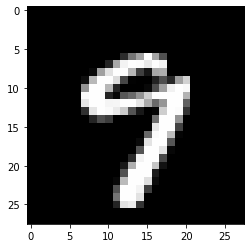

9

In [348]:
# Seeing our network in action

import matplotlib.pyplot as plt

# pick a sample to plot
sample = 50099
image = train_X[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

net = setInput(net, train_X[sample])
networkOutput = np.argmax(net.a[-1])
networkOutput